# ELG7186 - Winter 2022 - Assignment 3
## Due: <strong>Monday March 21<sup>st</sup> 2022 -- 11:59pm</strong>

In this assignment, you will apply your knowledge of CNNs we want to estimate the growth stage of weeds using the number of leaves of the plant. The more leaves, the more the weed has grown.

The purpose of this assignment is to gain experience building and training neural networks. You will gain:
- More experience training CNNs
- Experience with problem reformulation
- Experience with techniques for improving results (Regularization, Data Augmentation)

You must use Keras with the Tensorflow backend, i.e., the package tensorflow.keras. For this assignment, you may use other tensorflow packages and scikit-learn, scikit-image or pandas but not other deep learning frameworks, e.g., pytorch, mxnet etc.

### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


### DO NOT submit any images from the dataset

## Part 0. Data Preparation

The data for this assignment are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> (Required files are posted on Brightspace)

However, you must work with the subset of images posted on BrightSpace as training.zip and testing.zip. There are 200 images for each of the 5 classes. As Figure 1 shows, there is a great variety of plants and image conditions. The dataset is split into a training and a testing set where there are 180 images per class for training and validation; and 20 images for testing.




In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Use the splits provided in the Brightspace files</li>
<li>Visualize five images from the dataset.</li>
</ul>


In [1]:

# Prepare your dataset here
import os , shutil ,pathlib , math
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np
from skimage import io
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D , Rescaling , BatchNormalization
from tensorflow.keras.models import load_model ,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# split training data in to 
original_dir = "training"
categories = os.listdir(original_dir)
#make new directory for the images
#os.makedirs("train_validate")
# read the new directory in variable 
new_dir = "train_validate"
train_dir = new_dir + "/" + "train" # path for training data
valid_dir = new_dir + "/" + "valid" # path for validation data


for category in categories:
  # the directory that we will copy from
  dir = original_dir + "/" + category 
  # directory for training data
  copy_train_dir = train_dir+ "/" + category
  os.makedirs(copy_train_dir)

  # directory for validate data 
  copy_valid_dir = valid_dir + "/" + category
  os.makedirs(copy_valid_dir)

  # train _test_validate splitting
  count = len(os.listdir(dir))# the number of images in each class file 
  train = math.floor( count * 0.9 ) # 90% of images as training set 
  valid = math.floor( count * 0.1 ) # 10% as validation
  images = os.listdir(dir)

  valid_img = images[:valid]
  train_img = images[valid : ]

  #copying images to the new directories (/train ,/valid)

  for j in valid_img:
    shutil.copyfile(src = dir + "/"+ j ,
                     dst = copy_valid_dir +"/" + j)

  for k in train_img :
    shutil.copyfile(src = dir + "/" +k ,
                    dst = copy_train_dir + "/" +k)  




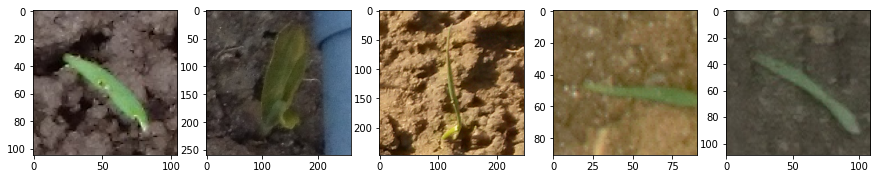

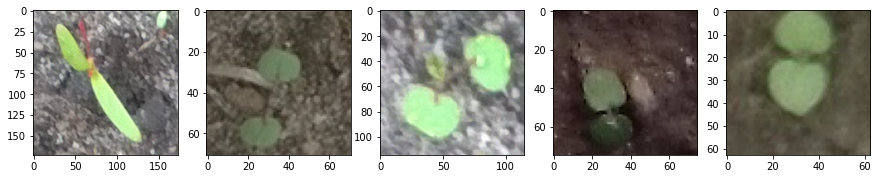

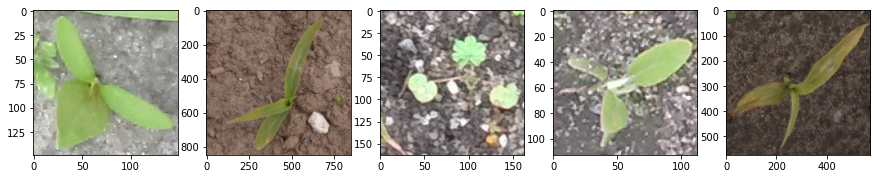

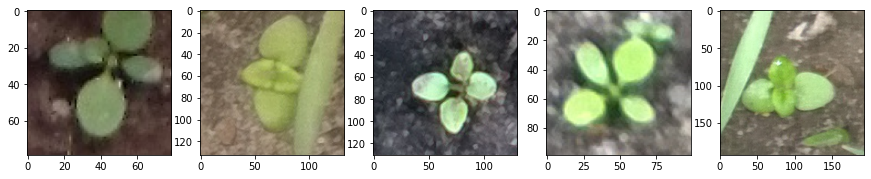

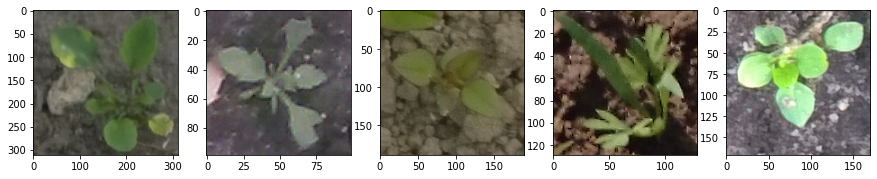

In [3]:
path = r"D:\cv3\training"
img_folders = os.listdir(path)
for i in img_folders:
  images_path = os.path.join(path , i)
  fig , axs = plt.subplots(1, 5 , figsize = (15 ,10))
  for ax in axs:
    fname = os.listdir(images_path)
    ran = fname[random.randint(0 ,len(fname)-1)]
    pic = io.imread(os.path.join(images_path , ran))
    ax.imshow(pic)
plt.show()
  

## Part 1a. Transfer Learning - Classification Network (3 Marks)
For this assignment, you are asked to use the Keras implementation of VGG-16 as a starting point. 

Using the first 2 blocks of VGG-16 add extra Keras layers to create your own version of a CNN network for the classification of the images according to the number of leaves in the plant images. Note that there will be 5 classes. The last layer from VGG-16 will be block2 pool and you are allowed to add no more than five fully connected or convolutional layers to the network including the final output layer. 

- You can use as many pooling, flattening, 1 × 1 convolution layers, etc. as you wish but do not use any regularization.
- Train this simple network on the training set while monitoring convergence on the validation set.
- As input to the model use images of size no larger than 128×128.

Note, it is highly recommended to use even smaller input images to try things out. You are not expected to fine-tune the initial VGG layers.

When your classifier is working:
- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.


In [2]:
# using image_dataset_from_directory to read images from directory with the folder names as the label 
# of the images  (it read images, resize them and pack them into batches ) 

from tensorflow.keras.utils import image_dataset_from_directory

img_size = 64
batch_size = 8

train_data = image_dataset_from_directory(r"D:\cv3\train_validate\train",
                                          image_size = (img_size,img_size),
                                          batch_size = batch_size
                                          )
test_data = image_dataset_from_directory(r"D:\cv3\testing",
                                          image_size = (img_size,img_size),
                                          batch_size = batch_size
                                          )
validate_data = image_dataset_from_directory(r"D:\cv3\train_validate\valid",
                                            image_size = (img_size,img_size),
                                             batch_size = batch_size
                                          )

Found 810 files belonging to 5 classes.
Found 100 files belonging to 5 classes.
Found 90 files belonging to 5 classes.


In [3]:
true = []
for batches , labels in test_data:
  print(" data batch shape : " , batches.shape)
  print(' label batch shape: ' , labels.shape)
  true.append(labels)
  break

 data batch shape :  (8, 64, 64, 3)
 label batch shape:  (8,)


In [4]:
X_train = np.concatenate([ x for x, y in train_data], axis=0)
y_train = np.concatenate([y for x, y in train_data], axis=0).astype("float64")

X_valid = np.concatenate([ x for x, y in validate_data], axis=0)
y_valid = np.concatenate([y for x, y in validate_data], axis=0).astype("float64")

X_test = np.concatenate([ x for x, y in test_data], axis=0)
y_test = np.concatenate([y for x, y in test_data], axis=0).astype("float64")

new_tr= []
for i in X_train:
    new_tr.append(i/255)
X_train = np.array(new_tr)

new_v = []
for i in X_valid:
    new_v.append(i/255)
X_valid = np.array(new_v)

new_ts = []
for i in X_test:
    new_ts.append(i/255)
X_test = np.array(new_ts)

print("X_train shape :  ",X_train.shape )
print("y_train shape :  ",y_train.shape )
print("X_valid shape :  ",X_valid.shape )
print("y_valid shape :  ",y_valid.shape )
print("X_test shape :  " ,X_test.shape  )
print("y_test shape :  " ,y_test.shape  )

X_train shape :   (810, 64, 64, 3)
y_train shape :   (810,)
X_valid shape :   (90, 64, 64, 3)
y_valid shape :   (90,)
X_test shape :   (100, 64, 64, 3)
y_test shape :   (100,)


In [5]:
mapping = {0:1, 1:2, 2:3 ,3:4 ,4:6 , 5:6 ,6:6}
k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

y_test = np.array(y_test)
y_test_ = np.zeros_like(y_test)
for key,val in zip(k,v):
    y_test_[ y_test == key] = val

y_test_ = y_test_.astype("int")


y_valid= np.array(y_valid)
y_val = np.zeros_like(y_valid)
for key,val in zip(k,v):
    y_val[ y_valid == key] = val

y_val = y_val.astype("int")


In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_cm(y_test ,y_predict ):
    conf_mx = confusion_matrix(y_test, y_predict)
    #print('Confusion matrix: \n{0}'.format(conf_mx))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=[1,2,3,4,6] ,)
    disp.plot()
    plt.show()

### Classification Network

In [6]:
#Write your VGG code here
vgg16 = keras.applications.vgg16.VGG16(weights = "imagenet",
                                      include_top = False ,
                                      input_shape = (img_size,img_size, 3))
model = keras.Sequential()
model.add(vgg16.layers[0])
model.add(vgg16.layers[1])
model.add(vgg16.layers[2])
model.add(vgg16.layers[3])
model.add(vgg16.layers[4])
model.add(vgg16.layers[5])
model.add(vgg16.layers[6])
for i in model.layers:
    i.trainable = False
model.add(Conv2D(256, (3,3) ,activation="relu"))
model.add(Conv2D(512, (3,3) ,activation="relu"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3) ,activation="relu"))
model.add(Conv2D(128, (3,3) ,activation="relu"))
model.add(MaxPooling2D((2,2), name = "pooling"))
model.add(Flatten())  
model.add(Dense(5 , activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 256)      

In [7]:
callbacks = [ keras.callbacks.ModelCheckpoint("base_model" ,
                                             save_best_only = True,
                                             monitor = 'val_loss') ,
              keras.callbacks.EarlyStopping(patience = 10,
                                           restore_best_weights = True)
             ]

model.compile(loss = "sparse_categorical_crossentropy" ,
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [8]:
# fit the model
history = model.fit(train_data ,
          epochs = 100,
          validation_data = validate_data )#,
         # callbacks = callbacks)

Epoch 1/100
102/102 [==============================] - 14s 129ms/step - loss: 181.8703 - accuracy: 0.2407 - val_loss: 1.7951 - val_accuracy: 0.3333
Epoch 2/100
102/102 [==============================] - 13s 122ms/step - loss: 1.6107 - accuracy: 0.3556 - val_loss: 1.6439 - val_accuracy: 0.2778
Epoch 3/100
102/102 [==============================] - 13s 125ms/step - loss: 1.4775 - accuracy: 0.3691 - val_loss: 1.6561 - val_accuracy: 0.2667
Epoch 4/100
102/102 [==============================] - 13s 128ms/step - loss: 1.2997 - accuracy: 0.4864 - val_loss: 1.9021 - val_accuracy: 0.2889
Epoch 5/100
102/102 [==============================] - 12s 122ms/step - loss: 1.3628 - accuracy: 0.4790 - val_loss: 2.0082 - val_accuracy: 0.2444
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 1.2661 - accuracy: 0.4975 - val_loss: 1.9619 - val_accuracy: 0.2222
Epoch 7/100
102/102 [==============================] - 11s 111ms/step - loss: 1.0672 - accuracy: 0.5716 - val_loss: 2.2076

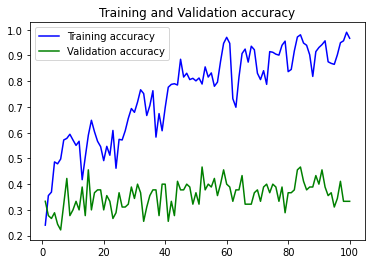

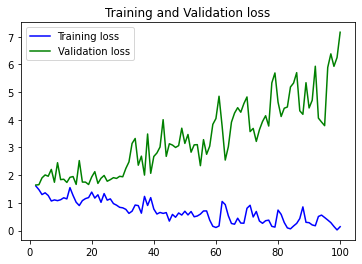

In [11]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1 ,len(accuracy ) + 1 )
 
plt.plot(epochs  ,accuracy  , 'b' , label = 'Training accuracy')
plt.plot(epochs  ,val_accuracy , 'g' , label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs[1:]  ,loss[1:] , 'b' , label = 'Training loss')
plt.plot(epochs[1:]  ,val_loss[1:], 'g' , label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()


In [7]:
test_model = keras.models.load_model("base_model")
test_loss , test_acc = test_model.evaluate(test_data)

13/13 [==============================] - 1s 47ms/step - loss: 1.6211 - accuracy: 0.3000


### test confusion matrix for classification model

In [65]:
pred = test_model.predict(test_data)
score = tf.nn.softmax(pred)
pred__= np.argmax(score , axis = 1)
mapping = {0:1, 1:2, 2:3 ,3:4 ,4:6 , 5:6 ,6:6}
k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

y_pred = np.zeros_like(pred__)
for key,val in zip(k,v):
    y_pred[pred__==key] = val
y_pred

array([6, 1, 4, 6, 1, 1, 2, 6, 3, 6, 6, 4, 2, 4, 6, 4, 4, 4, 2, 1, 1, 1,
       4, 2, 3, 2, 2, 3, 3, 6, 6, 4, 4, 6, 1, 4, 4, 4, 2, 4, 6, 3, 1, 2,
       6, 4, 2, 4, 2, 6, 2, 2, 1, 3, 1, 4, 1, 4, 6, 4, 6, 4, 4, 6, 4, 4,
       3, 4, 1, 6, 1, 1, 1, 1, 1, 4, 4, 4, 2, 2, 2, 1, 4, 4, 4, 6, 1, 1,
       6, 6, 6, 6, 4, 4, 4, 1, 1, 2, 6, 1], dtype=int64)

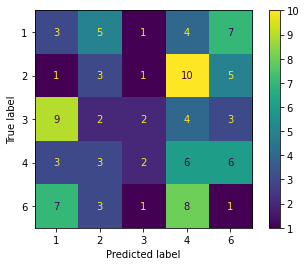

In [66]:
plot_cm(y_test_ , y_pred)

### validation confusion matrix for classification model

In [67]:
pred_val = test_model.predict(validate_data)
score = tf.nn.softmax(pred_val)
pred__= np.argmax(score , axis = 1)
mapping = {0:1, 1:2, 2:3 ,3:4 ,4:6 , 5:6 ,6:6}
k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

y_pred_val_1 = np.zeros_like(pred__)
for key,val in zip(k,v):
    y_pred_val_1[pred__==key] = val
y_pred_val_1

array([4, 1, 3, 2, 4, 6, 4, 4, 6, 4, 4, 6, 4, 6, 6, 1, 2, 6, 1, 6, 4, 1,
       4, 4, 6, 6, 2, 1, 2, 3, 6, 4, 6, 4, 3, 4, 4, 2, 4, 6, 6, 6, 1, 3,
       3, 2, 6, 1, 6, 6, 4, 3, 4, 4, 4, 2, 4, 1, 3, 2, 3, 4, 4, 6, 4, 3,
       4, 4, 4, 6, 1, 6, 4, 6, 6, 6, 4, 2, 4, 2, 4, 6, 4, 6, 4, 4, 6, 2,
       1, 6], dtype=int64)

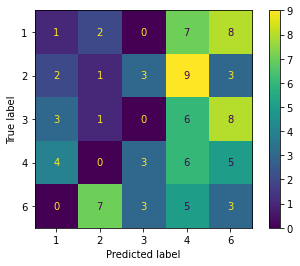

In [68]:
plot_cm(y_val , y_pred_val_1)

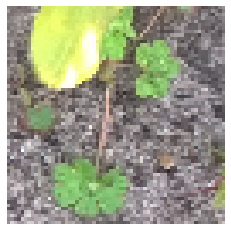

In [16]:
# for me to understand how model work in real live classification 
img = tf.keras.utils.load_img(r"D:\cv3\test_image.png", target_size=(img_size, img_size)
)
img_array = tf.keras.utils.img_to_array(img)
def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
plot_color_image(img_array)

In [17]:
img_array = tf.expand_dims(img_array, 0)
img_array.shape

TensorShape([1, 64, 64, 3])

In [18]:
predictions = test_model.predict(img_array)
prediction_score = tf.nn.softmax(predictions[0])
predicated_class = np.argmax(prediction_score)

prediction = np.zeros_like(predicated_class)
for key,val in zip(k,v):
    prediction[predicated_class==key] = val

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(prediction , 100 * np.max(prediction_score)))

This image most likely belongs to 2 with a 30.21 percent confidence.


## Part 1b. Transfer Learning - Regression Reformulation (3 Marks)

### Step 1 (2)
Repeat the steps of Part 1a. but reformulate as a regression problem, i.e., your network needs to output a single float value ranging between 0 to 6 corresponding to the number of leaves. Again, you are not expected to fine-tune the initial VGG layers.

- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.

### Step 2 (1)
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

In [20]:
# using "linear activation function" 
vgg16 = keras.applications.vgg16.VGG16(weights = "imagenet",
                                      include_top = False ,
                                      input_shape = (img_size,img_size, 3))
regressor = keras.Sequential()
regressor.add(vgg16.layers[0])
regressor.add(vgg16.layers[1])
regressor.add(vgg16.layers[2])
regressor.add(vgg16.layers[3])
regressor.add(vgg16.layers[4])
regressor.add(vgg16.layers[5])
regressor.add(vgg16.layers[6])
for i in regressor.layers:
    i.trainable = False

    
regressor.add(Conv2D(256,(3,3), activation='relu'))
regressor.add(Conv2D(512,(3,3), activation='relu'))
regressor.add(MaxPooling2D())

regressor.add(Conv2D(256,(3,3), activation='relu'))
regressor.add(Conv2D(128,(3,3), activation='relu'))
regressor.add(MaxPooling2D())

regressor.add(Flatten())
regressor.add(Dense(5))
regressor.add(Dense(1))


regressor.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 256)      

In [86]:
callbacks = [ keras.callbacks.ModelCheckpoint("regression_model" ,
                                             save_best_only = True,
                                             monitor = 'val_mae') ,
              keras.callbacks.EarlyStopping(patience = 15,
                                           restore_best_weights = True)]
regressor.compile(loss = "mse" ,
              optimizer =keras.optimizers.Adam(learning_rate=0.001),  
              metrics= ['mae'] )



In [88]:
# fit the model
history_regressor = regressor.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks = callbacks)
  
  

Epoch 1/100
102/102 [==============================] - 29s 288ms/step - loss: 2.2351 - mae: 1.2902 - val_loss: 2.1852 - val_mae: 1.2905
Epoch 2/100
102/102 [==============================] - 29s 285ms/step - loss: 2.1211 - mae: 1.2387 - val_loss: 2.1160 - val_mae: 1.2530
Epoch 3/100
102/102 [==============================] - 29s 281ms/step - loss: 1.9044 - mae: 1.1898 - val_loss: 2.2166 - val_mae: 1.2714
Epoch 4/100
102/102 [==============================] - 25s 243ms/step - loss: 1.6749 - mae: 1.0994 - val_loss: 2.3412 - val_mae: 1.2907
Epoch 5/100
102/102 [==============================] - 25s 249ms/step - loss: 1.3901 - mae: 0.9814 - val_loss: 2.4419 - val_mae: 1.3476
Epoch 6/100
102/102 [==============================] - 25s 242ms/step - loss: 1.1469 - mae: 0.8848 - val_loss: 2.3761 - val_mae: 1.3125
Epoch 7/100
102/102 [==============================] - 25s 247ms/step - loss: 1.0476 - mae: 0.8291 - val_loss: 2.6004 - val_mae: 1.3686
Epoch 8/100
102/102 [===========================

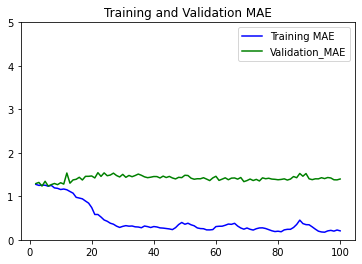

In [57]:
MAE = history_regressor.history['mae']
Val_MAE = history_regressor.history['val_mae']

Epochs = [i for i in range(1 ,len(MAE) + 1 )]
 
plt.plot(Epochs[1:] , MAE[1:]  , 'b' , label = 'Training MAE')
plt.plot(Epochs[1:]  ,Val_MAE[1:] , 'g' , label = 'Validation_MAE')
plt.title('Training and Validation MAE')
plt.ylim(0, 5)
plt.legend()


In [19]:
regressor = keras.models.load_model("regression_model")
mse_score , mae_score= regressor.evaluate(X_test, y_test, verbose=0)
mse_score ,  mae_score

(2.046635627746582, 1.225956916809082)

In [69]:

preds = regressor.predict(X_test)
predictions = []
for i in range(len(preds)):
    pr = int(np.round(((preds[i] - min(preds)) / (max(preds) - min(preds)))  * 6))
    predictions.append(pr)
predictions = np.array(predictions)


mapping = {0:1, 1:2, 2:3 ,3:4 ,4:6 , 5:6 ,6:6}
k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

y_pred_reg = np.zeros_like(predictions)
for key,val in zip(k,v):
    y_pred_reg[predictions == key] = val

y_pred_reg


array([3, 6, 6, 6, 3, 4, 4, 4, 2, 6, 4, 6, 6, 6, 4, 4, 4, 4, 2, 4, 4, 6,
       1, 2, 6, 3, 4, 4, 4, 3, 4, 6, 4, 3, 4, 3, 6, 4, 3, 6, 1, 6, 4, 6,
       3, 3, 2, 4, 4, 3, 6, 3, 6, 3, 4, 3, 6, 6, 3, 3, 2, 4, 6, 3, 6, 4,
       4, 6, 3, 3, 3, 3, 6, 4, 3, 2, 6, 6, 3, 4, 4, 3, 2, 4, 2, 2, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6])

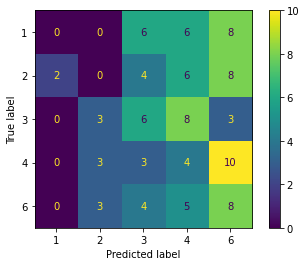

In [70]:
plot_cm(y_test_ , y_pred_reg )

In [71]:
pred_val2 = regressor.predict(X_valid)
predictions = []
for i in range(len(pred_val2)):
    pr = int(np.round(((pred_val2[i] - min(pred_val2)) / (max(pred_val2) - min(pred_val2)))  * 6))
    predictions.append(pr)
predictions = np.array(predictions)
mapping = {0:1, 1:2, 2:3 ,3:4 ,4:6 , 5:6 ,6:6}
k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

y_pred_reg_val = np.zeros_like(predictions)
for key,val in zip(k,v):
    y_pred_reg_val[predictions == key] = val

y_pred_reg_val


array([4, 1, 6, 4, 6, 2, 3, 4, 2, 3, 3, 4, 3, 3, 4, 3, 4, 3, 1, 2, 1, 3,
       3, 3, 6, 4, 2, 3, 2, 6, 4, 4, 4, 3, 6, 3, 3, 6, 4, 2, 4, 2, 3, 2,
       3, 3, 3, 3, 6, 2, 3, 6, 6, 4, 6, 3, 4, 2, 6, 4, 4, 4, 4, 3, 6, 2,
       6, 3, 6, 3, 6, 1, 3, 3, 4, 3, 2, 6, 2, 3, 6, 3, 4, 2, 2, 6, 4, 2,
       3, 4])

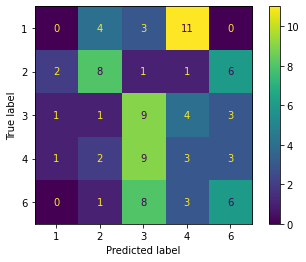

In [72]:
plot_cm(y_val , y_pred_reg_val)

###part 1 discussion 
#### by training the above model for classification and regression we get a savere overfitting in absence of any regularization technique and with a small number of images ,
#### for classification model we got :  
    96.6% for training accuracy , 33 % for validation accuracy , 1.34 training loss and 1.54 val_loss without using earlystopping technique, when we use it with a patience of 10 epoches , we got 47% for training accuracy , 43% fo valid accuracy  ,30 % testing accuracy ,0.13 for loss and  0.16 for val_loss.

#### for regression model we got : 
    0.079 for training loss(MSE)  , 2.7 val loss(MSE) , 0.205 for MAE and 1.39 for val-loss for 100 epochs (overfitting and underfitting)  , while using early stopping we got 1.98 loss(mse) ,2.03 val-loss(mse) , 1.20 mae and 1.22 val-mae (only underfitting is occurred )
    
    by comparing two confusion matrix and classification report for both regression and classification we can observe that classification achieve  better than regression a little bit  

#### for confusion matrics :
     its unusual to plot confusion matrix for validation but here we tried to check the performance of the model in both testing and validation setwe observe that is has approximately the same performance in both of them 

###  using regularization may help in control and reduce the overfitting and  increasing the  number of images(training data) surely will incearse the classification accuracy 

## Part 2. Improve your Model (4 Marks)

Regularization and data augmentation are common strategies to deal with small datasets.

### Step 1 (1.5)
Incorporate Batch Normalization and Dropout into your design the superior network trained in Part 1. You are not expected to fine-tune the initial VGG layers. Again you will provide the following:
- A loss curve for training and validation data
- An accuracy curve for training and validation data
- A confusion matrix of your network on the training including validation and testing data sets.
 

### Step 2 (1.5)
Train the same model from Step 1, now using data augmentation. Again, please provide the same output metrics as in Step 1.

### Step 3 (1)
Discuss based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

### 2.1 Using Regularization


In [92]:
# Write your code here
#Write your VGG code here

model_regu = keras.Sequential()
model_regu.add(vgg16.layers[0])
model_regu.add(vgg16.layers[1])
model_regu.add(vgg16.layers[2])
model_regu.add(vgg16.layers[3])
model_regu.add(vgg16.layers[4])
model_regu.add(vgg16.layers[5])
model_regu.add(vgg16.layers[6])
for i in model_regu.layers:
    i.trainable = False
model_regu.add(BatchNormalization())

model_regu.add(Conv2D(256, (3,3) ,activation="relu"))
model_regu.add(BatchNormalization())
model_regu.add(Dropout(0.5))

model_regu.add(Conv2D(512, (3,3) ,activation="relu"))
model_regu.add(BatchNormalization())
model_regu.add(Dropout(0.5))
model_regu.add(MaxPooling2D((2,2)))

model_regu.add(Conv2D(256, (3,3) ,activation="relu"))
model_regu.add(BatchNormalization())
model_regu.add(Dropout(0.5))

model_regu.add(Conv2D(128, (3,3) ,activation="relu"))
model_regu.add(BatchNormalization())
model_regu.add(Dropout(0.5))

model_regu.add(Flatten())  
model_regu.add(Dense(5 , activation = 'softmax'))


callbacks = [ keras.callbacks.ModelCheckpoint("model_regu_from_scratch" ,
                                             save_best_only = True,
                                             monitor = 'val_loss') ,
              keras.callbacks.EarlyStopping(patience = 10,
                                           restore_best_weights = True)
             ]

model_regu.compile(loss = "sparse_categorical_crossentropy" ,
              optimizer = 'adam', 
              metrics = ['accuracy'])

model_regu.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_57 (Bat  (None, 16, 16, 128)    

In [93]:
# fit the model
history = model_regu.fit(train_data ,
          epochs = 100,
          validation_data = validate_data ,
          callbacks = callbacks)

Epoch 1/100
102/102 [==============================] - 32s 305ms/step - loss: 2.3764 - accuracy: 0.2691 - val_loss: 3.9839 - val_accuracy: 0.2222
Epoch 2/100
102/102 [==============================] - 37s 358ms/step - loss: 1.8028 - accuracy: 0.3877 - val_loss: 2.1973 - val_accuracy: 0.3222
Epoch 3/100
102/102 [==============================] - 28s 276ms/step - loss: 1.6262 - accuracy: 0.4630 - val_loss: 1.5224 - val_accuracy: 0.3444
Epoch 4/100
102/102 [==============================] - 26s 257ms/step - loss: 1.4384 - accuracy: 0.5099 - val_loss: 1.6631 - val_accuracy: 0.4556
Epoch 5/100
102/102 [==============================] - 28s 272ms/step - loss: 1.1666 - accuracy: 0.5765 - val_loss: 2.0979 - val_accuracy: 0.3667
Epoch 6/100
102/102 [==============================] - 26s 257ms/step - loss: 1.0679 - accuracy: 0.5988 - val_loss: 1.8432 - val_accuracy: 0.4778
Epoch 7/100
102/102 [==============================] - 26s 255ms/step - loss: 1.0000 - accuracy: 0.6395 - val_loss: 1.6715 -

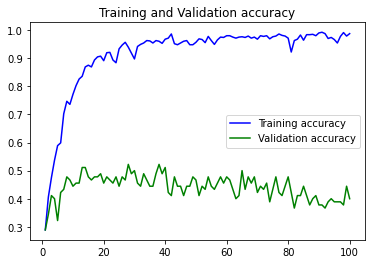

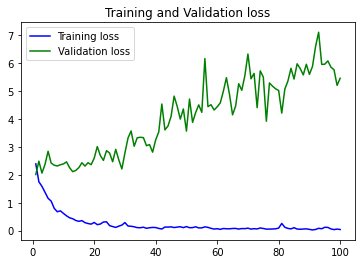

In [33]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy'] 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1 ,len(accuracy ) + 1 )
 
plt.plot(epochs  ,accuracy  , 'b' , label = 'Training accuracy')
plt.plot(epochs  ,val_accuracy , 'g' , label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
# plt.ylim(0 , 0.02)
plt.legend()

plt.figure()

plt.plot(epochs  ,loss , 'b' , label = 'Training loss')
plt.plot(epochs  ,val_loss , 'g' , label = 'Validation loss')
plt.title('Training and Validation loss')

plt.legend()

In [25]:
model_regu = keras.models.load_model("Model_regu_from_scratch")
test_loss_regu , test_acc_regu = model_regu.evaluate(test_data)


13/13 [==============================] - 1s 53ms/step - loss: 1.5676 - accuracy: 0.3600


### confusion matrix for testing set

In [73]:
pred_regu = model_regu.predict(test_data)
score_regu = tf.nn.softmax(pred_regu)
pred_regu= np.argmax(score_regu , axis = 1)
mapping = {0:1, 1:2, 2:3 ,3:4 ,4:6}
k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

y_pred_regu = np.zeros_like(pred_regu)
for key,val in zip(k,v):
    y_pred_regu[pred_regu==key] = val
y_pred_regu

array([4, 6, 6, 3, 6, 4, 3, 6, 6, 1, 6, 6, 6, 2, 2, 2, 4, 6, 6, 6, 2, 4,
       4, 6, 4, 6, 1, 4, 6, 6, 4, 2, 2, 6, 3, 1, 4, 4, 2, 2, 4, 2, 6, 4,
       6, 6, 1, 4, 1, 4, 6, 4, 6, 6, 3, 6, 6, 2, 1, 6, 6, 6, 6, 6, 1, 2,
       6, 6, 4, 2, 1, 2, 6, 6, 6, 6, 1, 4, 6, 2, 1, 6, 2, 3, 6, 6, 6, 6,
       1, 2, 6, 1, 4, 6, 6, 4, 6, 6, 1, 1], dtype=int64)

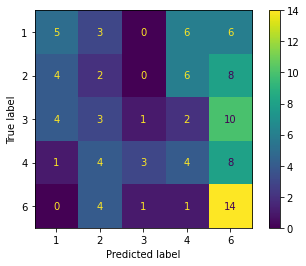

In [74]:
plot_cm(y_test_ , y_pred_regu)

### confusion matrix for validation set

In [75]:
pred_regu_val = model_regu.predict(validate_data)
score_regu_val = tf.nn.softmax(pred_regu_val)
pred_regu_val= np.argmax(score_regu_val , axis = 1)
mapping = {0:1, 1:2, 2:3 ,3:4 ,4:6}
k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

y_pr_val = np.zeros_like(pred_regu_val)
for key,val in zip(k,v):
    y_pr_val[pred_regu_val==key] = val
y_pr_val

array([6, 6, 6, 3, 4, 6, 4, 4, 6, 6, 6, 6, 1, 2, 1, 3, 6, 4, 2, 6, 6, 6,
       1, 1, 6, 4, 6, 6, 6, 1, 2, 4, 6, 6, 1, 2, 4, 6, 6, 6, 2, 4, 2, 1,
       6, 3, 3, 1, 6, 2, 6, 6, 6, 2, 6, 6, 4, 6, 1, 2, 4, 6, 1, 4, 2, 4,
       6, 6, 4, 3, 6, 6, 2, 6, 6, 6, 6, 6, 4, 4, 3, 2, 6, 4, 6, 4, 6, 1,
       4, 2], dtype=int64)

In [76]:
y_valid

array([0., 3., 4., 0., 1., 0., 2., 3., 3., 3., 2., 0., 4., 3., 0., 2., 4.,
       0., 1., 0., 2., 2., 4., 0., 2., 4., 0., 3., 4., 4., 0., 2., 2., 4.,
       3., 3., 4., 4., 3., 3., 2., 1., 2., 1., 3., 2., 3., 0., 2., 2., 2.,
       4., 1., 0., 1., 4., 0., 1., 1., 4., 3., 1., 0., 2., 2., 1., 1., 3.,
       1., 3., 3., 1., 1., 4., 0., 2., 1., 4., 0., 4., 4., 4., 0., 1., 1.,
       3., 0., 1., 3., 2.])

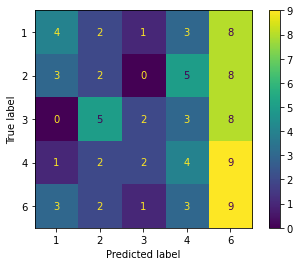

In [77]:
plot_cm(y_val , y_pr_val)

### 2.2 using augmentation

In [ ]:
# augmentation 
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from PIL import Image
import os, os.path

datagen = ImageDataGenerator(
        rotation_range=70,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        fill_mode='nearest') 



original_dir = r"D:\cv3\training"
categories = os.listdir(original_dir)
os.makedirs("augmented")
aug_dir = r"D:\cv3\augmented"

for category in categories:
    input_path = os.path.join(original_dir ,category)
    output_path =os.path.join(aug_dir,category)
    for filename in os.listdir(input_path):
        im = Image.open(filename)
        x = img_to_array(im)
        x = x.reshape((1,) + x.shape)
        i =0 
        for batch in datagen.flow(x,
                          batch_size=1,
                          save_to_dir= output_path,
                          save_prefix='a', 
                          save_format='png'):
            i += 1
            if i > 5:
              break  


In [37]:
train_aug = image_dataset_from_directory(r"D:\cv3\augmented",
                                          image_size = (img_size,img_size),
                                          batch_size = batch_size)

Found 5131 files belonging to 5 classes.


In [175]:
# Write your code here
#Write your VGG code here

model_aug = keras.Sequential()
model_aug.add(vgg16.layers[0])
model_aug.add(vgg16.layers[1])
model_aug.add(vgg16.layers[2])
model_aug.add(vgg16.layers[3])
model_aug.add(vgg16.layers[4])
model_aug.add(vgg16.layers[5])
model_aug.add(vgg16.layers[6])
for i in model_aug.layers:
    i.trainable = False
    
model_aug.add(BatchNormalization())

model_aug.add(Conv2D(256, (3,3) ,activation="relu"))
model_aug.add(BatchNormalization())
model_aug.add(Dropout(0.5))

model_aug.add(Conv2D(512, (3,3) ,activation="relu"))
model_aug.add(BatchNormalization())
model_aug.add(Dropout(0.5))
model_aug.add(MaxPooling2D((2,2)))

model_aug.add(Conv2D(256, (3,3) ,activation="relu"))
model_aug.add(BatchNormalization())
model_aug.add(Dropout(0.5))

model_aug.add(Conv2D(128, (3,3) ,activation="relu"))
model_aug.add(BatchNormalization())
model_aug.add(Dropout(0.5))

model_aug.add(Flatten())  
model_aug.add(Dense(5 , activation = 'softmax'))

callbacks = [ keras.callbacks.ModelCheckpoint("model_aug_from_scratch" ,
                                             save_best_only = True,
                                             monitor = 'val_loss') ,
              keras.callbacks.EarlyStopping(patience = 10,
                                           restore_best_weights = True)
             ]

model_aug.compile(loss = "sparse_categorical_crossentropy" ,
              optimizer = 'adam', 
              metrics = ['accuracy'])

model_aug.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_115 (Ba  (None, 16, 16, 128)    

In [176]:
# fit the model
history_aug = model_aug.fit(train_aug,
          epochs = 100,
          validation_data = validate_data,
          callbacks = callbacks)

Epoch 1/100
642/642 [==============================] - 236s 366ms/step - loss: 2.4765 - accuracy: 0.3385 - val_loss: 2.4782 - val_accuracy: 0.4000
Epoch 2/100
642/642 [==============================] - 235s 366ms/step - loss: 1.9405 - accuracy: 0.4455 - val_loss: 1.5014 - val_accuracy: 0.5444
Epoch 3/100
642/642 [==============================] - 235s 366ms/step - loss: 1.5812 - accuracy: 0.4944 - val_loss: 1.3078 - val_accuracy: 0.6111
Epoch 4/100
642/642 [==============================] - 230s 358ms/step - loss: 1.3869 - accuracy: 0.5486 - val_loss: 1.0506 - val_accuracy: 0.5667
Epoch 5/100
642/642 [==============================] - 251s 390ms/step - loss: 1.1519 - accuracy: 0.5919 - val_loss: 1.0191 - val_accuracy: 0.6333
Epoch 6/100
642/642 [==============================] - 255s 397ms/step - loss: 0.9945 - accuracy: 0.6311 - val_loss: 0.8600 - val_accuracy: 0.7000
Epoch 7/100
642/642 [==============================] - 247s 385ms/step - loss: 0.9366 - accuracy: 0.6498 - val_loss: 0

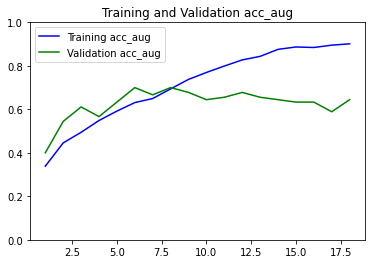

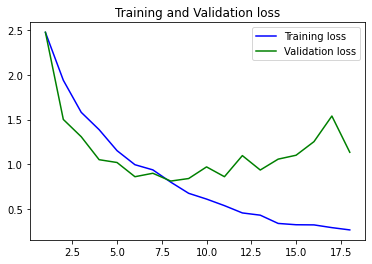

In [177]:
acc_aug = history_aug.history['accuracy']
val_acc_aug = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(1 ,len(acc_aug ) + 1 )
 
plt.plot(epochs  ,acc_aug  , 'b' , label = 'Training acc_aug')
plt.plot(epochs  ,val_acc_aug , 'g' , label = 'Validation acc_aug')
plt.title('Training and Validation acc_aug')
plt.ylim(0 , 1)
plt.legend()

plt.figure()

plt.plot(epochs  ,loss , 'b' , label = 'Training loss')
plt.plot(epochs  ,val_loss , 'g' , label = 'Validation loss')
plt.title('Training and Validation loss')

plt.legend()

In [33]:
test_model_aug = keras.models.load_model("model_aug_from_scratch")
test_loss_aug , test_acc_aug = test_model_aug.evaluate(test_data)

13/13 [==============================] - 1s 56ms/step - loss: 1.2192 - accuracy: 0.5200


#### plotting testing confusion matrix 


In [78]:
pred_val = test_model_aug.predict(test_data)
score_aug = tf.nn.softmax(pred_val)
pred_val= np.argmax(score_aug , axis = 1)
mapping = {0:1, 1:2, 2:3 ,3:4 ,4:6}
k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

y_pred_val = np.zeros_like(pred_val)
for key,val in zip(k,v):
    y_pred_val[pred_val==key] = val
y_pred_val



array([1, 3, 3, 3, 6, 6, 3, 3, 3, 6, 2, 6, 2, 1, 2, 1, 6, 1, 1, 1, 3, 6,
       6, 2, 1, 3, 2, 6, 4, 2, 3, 6, 2, 2, 1, 4, 3, 6, 1, 1, 3, 3, 6, 4,
       3, 2, 1, 3, 2, 3, 1, 3, 1, 6, 2, 3, 3, 3, 6, 2, 1, 6, 3, 2, 2, 6,
       3, 6, 6, 6, 6, 2, 6, 6, 1, 1, 3, 6, 1, 2, 1, 6, 2, 2, 1, 4, 2, 6,
       3, 1, 2, 2, 2, 3, 2, 4, 1, 3, 3, 3], dtype=int64)

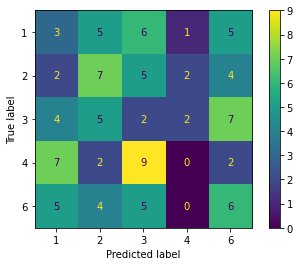

In [79]:
plot_cm(y_test ,pred_val)

#### plotting valdition confusion matrix 


In [102]:
pred_aug = test_model_aug.predict(validate_data)
score_aug_ = tf.nn.softmax(pred_aug)
pred_val_= np.argmax(score_aug_ , axis = 1)
mapping = {0:1, 1:2, 2:3 ,3:4 ,4:6}
k = np.array(list(mapping.keys()))
v = np.array(list(mapping.values()))

y_pred_aug_v = np.zeros_like(pred_val_)
for key,val in zip(k,v):
    y_pred_aug_v[pred_val_==key] = val
y_pred_aug_v

array([2, 2, 3, 3, 4, 6, 3, 6, 6, 2, 2, 3, 1, 6, 6, 2, 6, 2, 2, 1, 2, 4,
       1, 1, 1, 6, 4, 1, 6, 4, 2, 3, 3, 1, 3, 2, 1, 6, 6, 2, 4, 1, 6, 1,
       4, 2, 3, 1, 6, 6, 4, 3, 1, 2, 3, 6, 6, 3, 3, 1, 3, 6, 6, 6, 1, 2,
       3, 1, 1, 1, 3, 2, 4, 1, 3, 4, 1, 1, 1, 2, 1, 2, 6, 3, 2, 4, 2, 3,
       3, 2], dtype=int64)

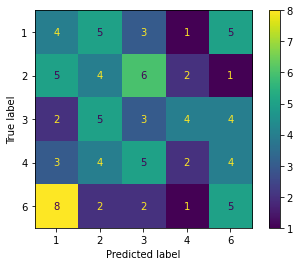

In [103]:
plot_cm(y_val , y_pred_aug_v)

## discussion 

### regulartzation model :

We discovered that using dropout and batch normalization only delayed overfitting for a few epochs and did not solve the problem, as we got 98 percent, 48 percent, and 36 percent accuracy for training, validation, and testing, 0.3 and 5.7 for loss and Val loss for 100 epochs produce severe overfitting and using early stopping it stopped on epoch 13 with 84 percent and 0.53 for training and validation accuracy, and 36 percent for testing accuracy.

    
### augmentation model:

 after using the augmentation we got 90% and 64% for training and validation accuracy, 0.26 and 1.113 loss and validation loss,  when we used early stopping we observed that the moel began to overfit after epoch 8  with patience equal to 10 epochs we stop training as the loss continue to increase, we used ModelChechPoint callback to save the model at the best epoch which was epoch 8 with 69.4% and 70% for training and validation accuracy with 0.799 and 0.8 for loss and validation loss, we see that the level of overfitting and the level of underfitting are reduced as the difference between the training accuracy and validation accuracy is decreased and the accuracies themselves increased while it still far from the desired results.

### final notice

so we need to change the structure of the model , as you asked not to change the model so it's clearly observed   that the user of the same model is not suitable when the data is increased or when the regularization is added,I think we need to a trait with each model as a different use case so we can play around with each model to enhance the performance of the model and training a deep learning model shouldn't be restricted to only change the techniques used, so the hyperparameters should be change for each model structure and not be the same .

## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.
